In [1]:
!nvidia-smi

Mon May 22 17:25:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 45%   32C    P8    N/A /  75W |    506MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import Libary
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from matplotlib.ticker import MaxNLocator

import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from wordcloud import WordCloud

import gensim
from gensim import models
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases, CoherenceModel
import gensim.corpora as corpora

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Load Dataset

In [3]:
# Load Dataset
df = pd.read_csv("../dataset/gmaps_review_dataset - labelling - review.csv")

In [4]:
# Show first 5 rows
df.head()

,id,PIC,datetime,date status,scrapped_at,location,rating,text,aksesibilitas,fasilitas (akomodasi dan amenitas),aktivitas (atraksi dan aktivitas)
0,47d0cdd937754bd6b860f89b2bab1dbb,Fakhri,2022-05-15 11:58:43,Valid,2023-02-15 11:58:43,Curug Malela,4,Akses jalannya waktu itu masih sulit di jangka...,2,0,0
1,4804acd6c05e4f89b098e2ca35019419,Fakhri,2022-08-15 11:58:43,Valid,2023-02-15 11:58:43,Curug Malela,5,"Perjalanan yg bnr"" bikin Syahduu ,, dr Tempat ...",1,0,1
2,3eae265bf32a45eca31765a4145bc030,Fakhri,2022-03-15 11:58:43,Valid,2023-02-15 11:58:43,Curug Malela,5,"Minggu 13 februari 2022 ,\n\ngas santai pakai ...",1,2,1
3,61037dbdb7b14045be49d4494e95cf05,Fakhri,2022-05-15 11:58:44,Valid,2023-02-15 11:58:44,Curug Malela,5,7 mei 2022\nTouring bari mudik\nMntap perjalan...,1,0,1
4,a2c9e817e2b949c6880f971f43a11d2f,Fakhri,2022-08-15 11:58:44,Valid,2023-02-15 11:58:44,Curug Malela,5,Perjalanan touring motor dari bekasi melewati ...,0,0,1


In [5]:
# Rename column
df = df.rename(columns={'date status':'status'})

In [6]:
# Drop column
df = df.drop(columns=['PIC', 'scrapped_at', 'rating', 'aksesibilitas', 'fasilitas (akomodasi dan amenitas)', 'aktivitas (atraksi dan aktivitas)'])

In [7]:
# Show lenght and type of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13587 entries, 0 to 13586
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        13587 non-null  object
 1   datetime  13587 non-null  object
 2   status    13587 non-null  object
 3   location  13587 non-null  object
 4   text      13587 non-null  object
dtypes: object(5)
memory usage: 530.9+ KB


In [8]:
# Convert column type to datetime type
df['datetime'] = df['datetime'].apply(pd.to_datetime)

# Preprocessing

## Data Filtering

In [9]:
print(f'Length data before processing: {len(df)}')

Length data before processing: 13587


In [10]:
mask = (df['datetime'] >= '2019-1-1')
df = df.loc[mask]

In [11]:
df = df[df['location'] != 'Situ Lembang Dano']

In [12]:
df = df[df['status'] != 'Invalid']

In [13]:
df = df.drop_duplicates(subset=['text'])

In [14]:
print(f'Length data after processing: {len(df)}')

Length data after processing: 11658


## Data Cleaning

In [15]:
def get_translate_text(text):
    keyword = ['(Diterjemahkan oleh Google)', '(Asli)']
    if keyword[0] in text and keyword[1] in text:
        text = text[text.find(keyword[0]) + len(keyword[0]):text.rfind(keyword[1])]
    elif keyword[0] in text and keyword[1] not in text:
        text = text[text.find(keyword[0]) + len(keyword[0]):]
    return text 

In [16]:
def clean_text(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r' ', text) # no emoji
    text = text.lower() #to lowercase
    text = re.sub('\n', ' ', text) #remove \n
    text = re.sub(r'[^\w\s]', ' ', text) #remove punctuation
    text = re.sub("\d+", "", text) #remove number
    text = re.sub(' +', ' ', text) #remove multiple whitespace
    
    if re.search(r'([a-zA-Z])\1{2,}', text): # Spell
        text = re.sub(r'([a-zA-Z])\1{2,}','\\1', text)
        
    return text

In [17]:
df['text_preprocess'] = df['text'].apply(get_translate_text)
df['text_preprocess'] = df['text_preprocess'].apply(clean_text)
df['len_char'] = df['text_preprocess'].apply(lambda x: len(x))
df['len_word'] = df['text_preprocess'].apply(lambda x: len(x.split(' ')))

In [18]:
# df.head()

In [19]:
# df[df['id'] == '3452054e89614078a257967adbbee4b6']

## Tokenizing

In [20]:
df['tokens'] = df['text_preprocess'].apply(lambda x: word_tokenize(x))

In [21]:
# df['tokens']

## Stopwords removal

In [22]:
stop_words = StopWordRemoverFactory().get_stop_words()
extend_stopword = [
    'pas', 'yg', 'tp', 'rb', 'km', 'tp', 'dg', 'dr',
    'bagu','bagus','bagusnya',
    'banyaknya','banyakny','banyak',
    'jlan','jalan',
    'masuk','tempat',
    'atas','sana','karna','sama','saya','sudah','udah','mungkin', 'tuji','jadi','saja','sini','kalo','kalau',
    'untuk','semua','buat','bisa','cuma','sangat','buat','unutk','paling','cukup','naik','ribu','sekali',
    'benar','kesini','turun','sera','sayangny','anjur','mending','dapat', 'punya','mana','sekitar',
    'dapet','coba','bukan','sebut','sampe','tuju','hingga','beberapa','banget',
    'utk','gak','adl','dll','coba','klo','nya','pas','per','bnr','udh','lua','aja','bgt','lalu','krn','mau',
]

stop_words += extend_stopword

In [23]:
# from nltk.corpus import stopwords 

# stop_words = sorted(list(set(stopwords.words('indonesian')) - set(['jauh'])))
# stop_words.extend([
#     'pas', 'yg', 'tp', 'rb', 'km', 'tp', 'dg', 'dr', 'nya',
#     'bagu','bagus','bagusnya',
#     'banyaknya','banyakny','banyak',
#     'jlan','jalan',
#     'masuk','tempat',
#     'atas','sana','karna','sama','saya','sudah','udah','mungkin', 'tuji','jadi','saja','sini','kalo','kalau',
#     'untuk','semua','buat','bisa','cuma','sangat','buat','unutk','paling','cukup','naik','ribu','sekali',
#     'benar','kesini','turun','sera','sayangny','anjur','mending','dapat', 'punya','mana','sekitar',
#     'dapet','coba','bukan','sebut','sampe','tuju','hingga','beberapa','banget',
#     'utk','gak','adl','dll','coba','klo','nya','pas','per','bnr','udh','lua','aja','bgt','lalu','krn','mau',
# ])

In [24]:
df['tokens'] = df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

In [25]:
# df['tokens']

## Stemming

In [26]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
 
df['tokens'] = df['tokens'].apply(lambda x: stemmer.stem(' '.join(x)).split(' '))

In [27]:
# df['tokens']

In [28]:
# df.loc[df['id'] == '9d6e15357c5441078e33cf373d9b272d']

## Additional Step

In [29]:
def reduction_character_less_than_n(text):
    new_text = []
    char_less_than_threshold = 2
    length_word = len(text)
    for word_i in range(length_word):
        if len(text[word_i]) > char_less_than_threshold:
            new_text += [text[word_i]]
    
    return new_text

In [30]:
df['tokens'] = df['tokens'].apply(reduction_character_less_than_n)

In [31]:
# text = ['jalan', 'lumayan', 'jalur', 'mobil', 'pas', 'pas', 'mobil', 'parkir', 'jalan', 'kaki', 'ojeg', 'km', 'curug', 'tp', 'bayar', 'dg', 'pandang', 'curug', 'indah']
# text_new = reduction_character_less_than_n(text)
# text_new

In [32]:
df = df.drop_duplicates(subset=['text_preprocess'])

In [33]:
len(df)

11567

In [34]:
df['len_token'] = df['tokens'].apply(lambda x: len(x))

In [35]:
# df[df['len_token'] <= 3]

In [36]:
df = df[df['len_token'] >= 2]
df = df[df['len_token'] < 300]

In [83]:
print(f'Length data after processing: {len(df)}')

Length data after processing: 11046


In [85]:
# df.to_csv('../dataset/dataset_preprocess.csv', index=False)

# Explanatory Data Analysis

In [39]:
df['location'].value_counts()

Gunung Tangkuban Parahu           922
Floating Market Lembang           910
Curug Maribaya                    896
Terminal Wisata Grafika Cikole    894
Stone Garden                      892
Gunung Putri Lembang              879
Sarae Hills                       870
Orchid Forest Cikole              670
Curug Tilu Leuwi Opat             577
Taman Lembah DEWATA               498
Ciwangun Indah Camp (CIC)         433
Sanghyang Heuleut                 389
Curug Cimahi / Curug Pelangi      369
Kebun Begonia Lembang             358
Curug Layung Camp Situ Lembang    294
Sanghyang Kenit                   289
Bukit Senyum                      251
Curug Malela                      159
Taman Hutan Jayagiri Lembang      135
Curug Sawer Cililin               132
Situ Ciburuy                      103
Curug Halimun                      54
Curug Panganten                    42
Gunung Hawu                        27
Sirtwo Island Saguling              3
Name: location, dtype: int64

C:\Users\Fakhri\anaconda3\envs\aidev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='len_word'>

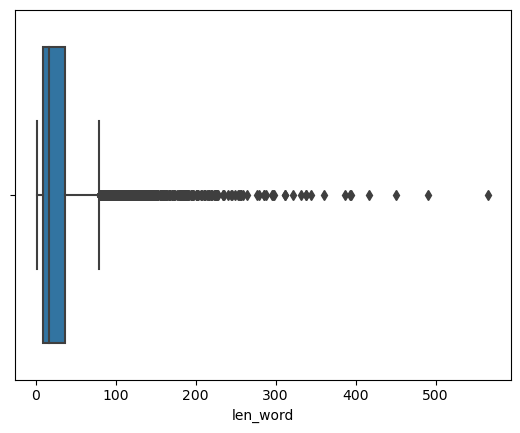

In [40]:
sns.boxplot(df['len_word'])

In [41]:
print('Q1:', df['len_word'].quantile(q=0.25))
print('Q2:', df['len_word'].quantile(q=0.5))
print('Q3:', df['len_word'].quantile(q=0.75))

Q1: 9.0
Q2: 17.0
Q3: 37.0


In [42]:
print('Mean:', df['len_word'].mean())

Mean: 29.242893355060655


In [43]:
df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

In [44]:
df['tokens'].values

array(['akses jalan waktu sulit jangkau jalan tuji curug lumayan',
       'jalan bikin syahduu parkir lokasi curug lelahh hilang lokasi',
       'minggu februari gas santai pakai motor dago jam parkir curug jam disasarin gps gunung halu percaya gps sasarin ikut tunjuk warga cililin jalan cor proyek blom beres bolong tengah ati oke tiket motor tiket parkir motor tagih pulang harga makan parkir nasi ayam sayur kacang gpp larisin guys kasi jual sana sepi oke star kaki parkir full trek turun berat nih pulang santai nikmat view jalan lumayan kudu ati ambil video curug menit jalan warung buka sayang sepi beli waktu kesana pasang sepi curugnya indah liat foto bersih sampah kesana bapa tugas beres lapin duduk sasapu baguss sayang jembatan foto kayu bolong licin ciprat air lapuk kudu akalin tuh cari bahan kuat air pokok kudu hati pis rawan jatoh oke nanjak dikit ketemu ojek situ diskus istri ojek debat ojek tarif tawar buset trek ekstrim licin nanjak tega gan tambahin ojek jdi motor rejeki coba

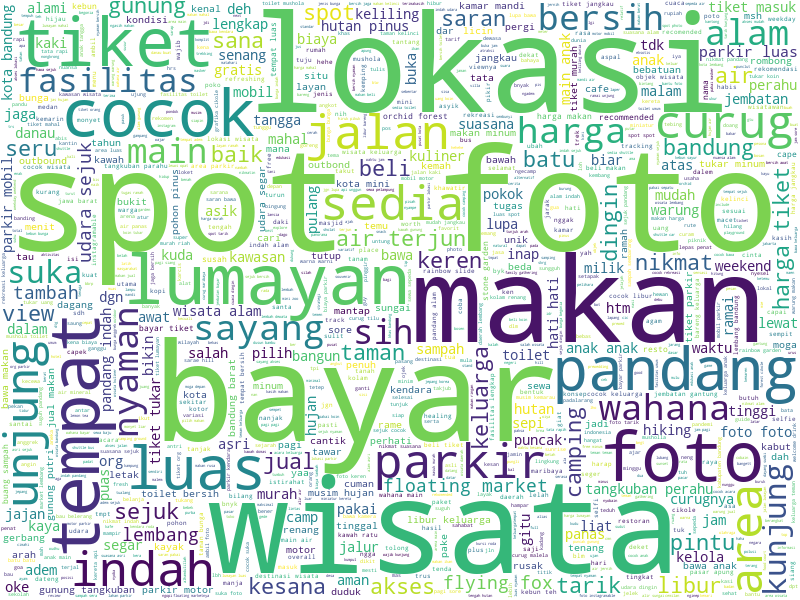

In [45]:
long_string = ''.join(df['tokens'].values)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=600)
wordcloud.generate(long_string)

wordcloud.to_image()

# Data Transformation

## Bigram & Trigram Models

In [46]:
texts = df['tokens'].apply(lambda x: word_tokenize(x))
texts = texts.reset_index(drop=True)

In [47]:
# bigram = Phrases(texts, min_count=10)
# trigram = Phrases(bigram[texts])

# for idx in range(len(texts)):
#     for token in bigram[texts[idx]]:
#         if '_' in token:
#             texts[idx].append(token)
#     for token in trigram[texts[idx]]:
#         if '_' in token:
#             texts[idx].append(token)

## Create corpus

In [48]:
# Initiate Corpus
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=5, no_above=0.2)

# texts = df['tokens']
# corpus = [id2word.doc2bow(text) for text in texts]

In [49]:
# BoW Corpus
corpus = [id2word.doc2bow(text) for text in texts]

In [50]:
# id2word = corpora.Dictionary(df['tokens'])
# texts = df['tokens']
# corpus = [id2word.doc2bow(text) for text in texts]

In [51]:
# TF-IDF Corpus
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Apply Model

In [52]:
def compute_coherence_values(id2word, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel( #LdaModel
                    corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, iterations=100,
                    # chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, 
                    # decay=0.5, offset=1.0, eval_every=10, gamma_threshold=0.001
                    )
        
        model_list.append(model)
        coherence_model = CoherenceModel(
                            model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

In [53]:
START = 1
LIMIT = 11
STEP = 1

model_list, coherence_values = compute_coherence_values(
    id2word=id2word, corpus=corpus, texts=texts, start=START, limit=LIMIT, step=STEP)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.26s/it]


# Evaluate

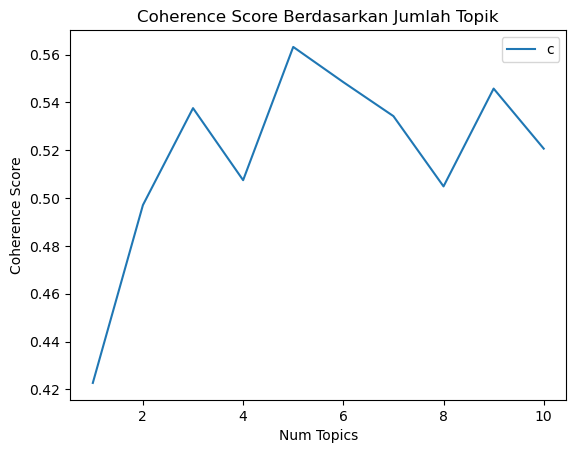

In [54]:
x = range(START, LIMIT, STEP)
plt.plot(x, coherence_values)
plt.title('Coherence Score Berdasarkan Jumlah Topik')
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
# plt.xticks(range(min(x), max(x)+1))
# plt.xlim(1, LIMIT-1)
# plt.xticks(coherence_values, x)
plt.legend(('coherence_values'), loc='best')
plt.show()

In [55]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    # print(f'{cv:.3f}')
    print(f'Num topics = {m}, has Coherence Score of {cv:.3f}')

Num topics = 1, has Coherence Score of 0.423
Num topics = 2, has Coherence Score of 0.497
Num topics = 3, has Coherence Score of 0.538
Num topics = 4, has Coherence Score of 0.507
Num topics = 5, has Coherence Score of 0.563
Num topics = 6, has Coherence Score of 0.548
Num topics = 7, has Coherence Score of 0.534
Num topics = 8, has Coherence Score of 0.505
Num topics = 9, has Coherence Score of 0.546
Num topics = 10, has Coherence Score of 0.521


In [65]:
model = model_list[4]

x = model.show_topics(num_topics=5, formatted=False)
# coherence_ldas = model.get_topics()
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

In [79]:
# # Below Code Prints Topics and Words
# for each_topic_coherence_score in enumerate(coherence_ldas):
#     print(f'Topic {each_topic_coherence_score[0]}: {each_topic_coherence_score[1]:.5f}')

In [67]:
# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(f'Topic {topic}: {words}')

Topic 0: ['foto', 'sejuk', 'tempat', 'nyaman', 'spot', 'keluarga', 'cocok', 'acara', 'suka', 'suasana']
Topic 1: ['wisata', 'foto', 'jalan', 'tangkuban', 'air', 'lokasi', 'bandung', 'gunung', 'tempat', 'tiket']
Topic 2: ['tiket', 'bayar', 'wisata', 'parkir', 'kawah', 'makan', 'harga', 'foto', 'spot', 'floating']
Topic 3: ['anak', 'makan', 'main', 'keluarga', 'cocok', 'wisata', 'sejuk', 'luas', 'tempat', 'bersih']
Topic 4: ['alam', 'hutan', 'dingin', 'indah', 'pandang', 'wisata', 'pinus', 'hujan', 'alami', 'suasana']


In [68]:
# Below Code Prints Topics and Words with probability
for idx, topic in model.print_topics(-1):
    print(f'Topic: {idx}, Word: {topic}')

Topic: 0, Word: 0.031*"foto" + 0.028*"sejuk" + 0.026*"tempat" + 0.024*"nyaman" + 0.021*"spot" + 0.019*"keluarga" + 0.016*"cocok" + 0.013*"acara" + 0.013*"suka" + 0.010*"suasana"
Topic: 1, Word: 0.019*"wisata" + 0.014*"foto" + 0.013*"jalan" + 0.013*"tangkuban" + 0.013*"air" + 0.012*"lokasi" + 0.012*"bandung" + 0.011*"gunung" + 0.011*"tempat" + 0.011*"tiket"
Topic: 2, Word: 0.022*"tiket" + 0.021*"bayar" + 0.021*"wisata" + 0.020*"parkir" + 0.017*"kawah" + 0.017*"makan" + 0.016*"harga" + 0.016*"foto" + 0.013*"spot" + 0.008*"floating"
Topic: 3, Word: 0.021*"anak" + 0.021*"makan" + 0.018*"main" + 0.017*"keluarga" + 0.016*"cocok" + 0.015*"wisata" + 0.015*"sejuk" + 0.015*"luas" + 0.014*"tempat" + 0.013*"bersih"
Topic: 4, Word: 0.024*"alam" + 0.018*"hutan" + 0.017*"dingin" + 0.016*"indah" + 0.015*"pandang" + 0.011*"wisata" + 0.011*"pinus" + 0.010*"hujan" + 0.010*"alami" + 0.010*"suasana"


In [ ]:
# len(model_list)

In [ ]:
# num_topics = 7

# lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)
# coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# coherence_ldas = coherence_model_lda.get_coherence_per_topic()

# print(f'Coherence Score with {num_topics} topic: {coherence_lda} \n')

# # Below Code Prints Topics and Words
# for each_topic_coherence_score in enumerate(coherence_ldas):
#     print(f'Topic {each_topic_coherence_score[0]}: {each_topic_coherence_score[1]:.5f}')

# x = lda_model.show_topics(num_topics=num_topics, formatted=False)
# topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# # Below Code Prints Topics and Words
# for topic, words in topics_words:
#     print(f'Topic {topic}: {words}')

In [80]:
model_temp = model_list[4]

C:\Users\Fakhri\anaconda3\envs\aidev\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Fakhri\anaconda3\envs\aidev\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


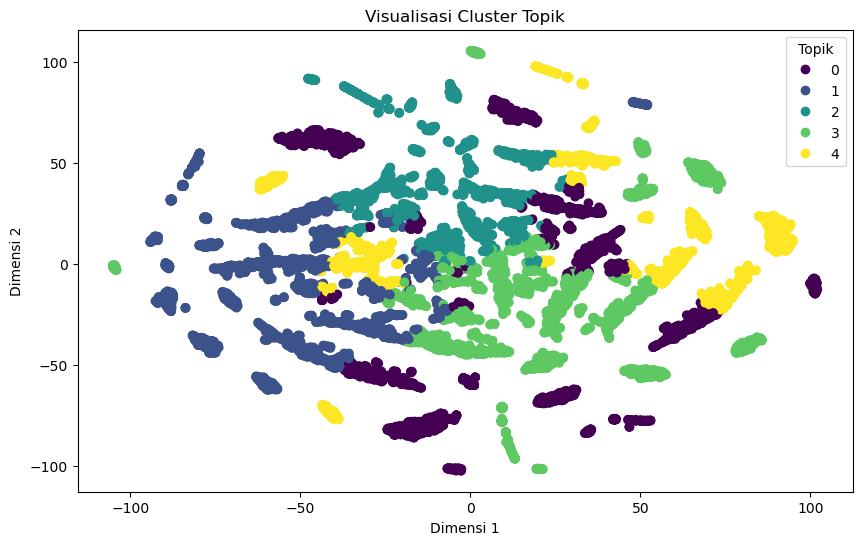

In [81]:
from sklearn.manifold import TSNE

# Mengambil matriks probabilitas topik untuk setiap dokumen
probabilitas_topik = np.zeros((len(corpus), 7))
for i, vektor_topik_dokumen in enumerate(model_temp[corpus]):
    for topik, probabilitas in vektor_topik_dokumen:
        probabilitas_topik[i, topik] = probabilitas

# Melakukan reduksi dimensi menggunakan t-SNE
model_tsne = TSNE(n_components=2, random_state=42)
data_tsne = model_tsne.fit_transform(probabilitas_topik)

# Mendapatkan label topik untuk setiap dokumen
label_topik = [vektor_topik_dokumen.argmax() for vektor_topik_dokumen in probabilitas_topik]

# Plot visualisasi cluster t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_topik)
plt.legend(*scatter.legend_elements(), title='Topik')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')
plt.title('Visualisasi Cluster Topik')
plt.show()

In [ ]:
probabilitas_topik

C:\Users\Fakhri\anaconda3\envs\aidev\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11027 samples in 0.012s...
[t-SNE] Computed neighbors for 11027 samples in 0.238s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11027
[t-SNE] Computed conditional probabilities for sample 2000 / 11027
[t-SNE] Computed conditional probabilities for sample 3000 / 11027
[t-SNE] Computed conditional probabilities for sample 4000 / 11027
[t-SNE] Computed conditional probabilities for sample 5000 / 11027
[t-SNE] Computed conditional probabilities for sample 6000 / 11027
[t-SNE] Computed conditional probabilities for sample 7000 / 11027
[t-SNE] Computed conditional probabilities for sample 8000 / 11027
[t-SNE] Computed conditional probabilities for sample 9000 / 11027
[t-SNE] Computed conditional probabilities for sample 10000 / 11027
[t-SNE] Computed conditional probabilities for sample 11000 / 11027
[t-SNE] Computed conditional probabilities for sample 11027 / 11027
[t-SNE] Mean sigma: 0.001162


C:\Users\Fakhri\anaconda3\envs\aidev\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.509521
[t-SNE] KL divergence after 1000 iterations: 0.815181


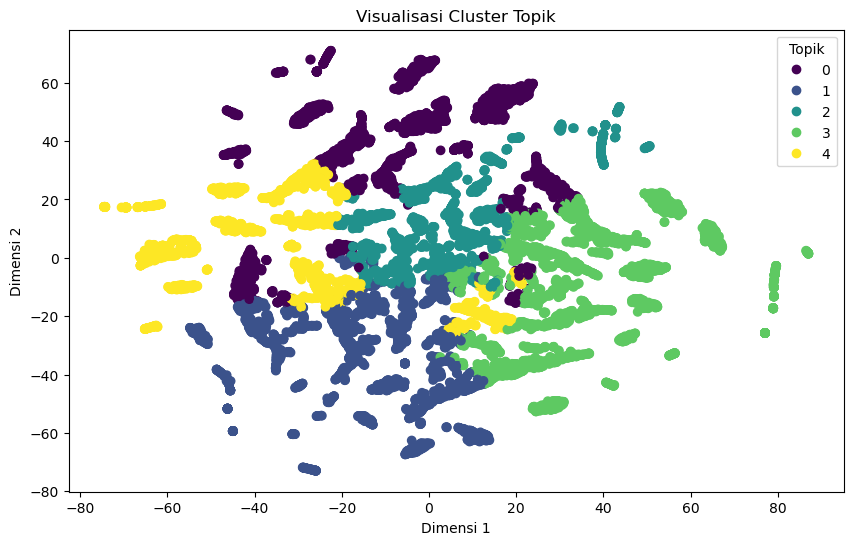

In [82]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Mengambil matriks probabilitas topik untuk setiap dokumen
topic_weights = np.zeros((len(corpus), 5))
for i, vektor_topik_dokumen in enumerate(model_temp[corpus]):
    for topik, probabilitas in vektor_topik_dokumen:
        topic_weights[i, topik] = probabilitas

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.25]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=topic_num)
plt.legend(*scatter.legend_elements(), title='Topik')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')
plt.title('Visualisasi Cluster Topik')
plt.show()

# n_topics = 5
# mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
# plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
#               plot_width=900, plot_height=700)
# plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

In [ ]:
x = lda_model.show_topics(num_topics=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic, words in topics_words:
    print(f'Topic {topic}: {words}')

#Below Code Prints Only Words 
# for topic,words in topics_words:
#     print(" ".join(words))

# Format Topic

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus_tfidf, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()

#Below Code Prints Topics and Words
for each_topic_coherence_score in enumerate(coherence_ldas):
    print(f'Topic {each_topic_coherence_score[0]}: {each_topic_coherence_score[1]:.5f}')

In [ ]:
for index, score in sorted(lda_model[corpus_tfidf[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
df.head()

In [ ]:
# df.to_excel("../dataset/dataset_preprocess.xlsx", index=False)

# Result

In [ ]:
# import pyLDAvis.gensim
# import pickle 
# import pyLDAvis
# # Visualize the topics
# pyLDAvis.enable_notebook()
# LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
# LDAvis_prepared